In [598]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import os
import skimage as ski
from skimage.transform import warp, AffineTransform, pyramid_expand, pyramid_reduce
import cv2
import scipy
from skimage.filters import unsharp_mask
from natsort import natsorted
from skimage.exposure import match_histograms
# from sklearn.mixture import GaussianMixture
from skimage.registration import phase_cross_correlation
from scipy import ndimage as scp
from tqdm import tqdm
from skimage.metrics import normalized_root_mse as nrm
# from statsmodels.tsa.stattools import acf
import pickle
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
from scipy.fftpack import fft2, fftshift, ifft2, fft, ifft
import time
import math
from skimage.exposure import equalize_hist
from skimage.exposure import equalize_adapthist
# from skimage.feature import SIFT, match_descriptors,plot_matches
# from skimage.feature import ORB
import ants.registration as ants_register
import ants
from scipy.optimize import minimize as minz
from scipy.optimize import dual_annealing,fmin_powell
from scipy import optimize
import pickle
from skimage.filters import threshold_otsu
from skimage.metrics import normalized_mutual_information as nmi
from skimage.metrics import mean_squared_error as mse
from tifffile import imread as tiffread
import sys
from util_funcs import *
import h5py

In [ ]:
path = f'scan5/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.h5'):
        pic_paths.append(i)
with h5py.File(path+pic_paths[0], 'r') as hf:
    original_data = np.array(hf['volume'])

original_data = original_data[:,200:,:]

In [566]:
# 264,1172-200

In [ ]:
# original_data = original_data[:,200:,:]

In [573]:

def ants_all_trans(data,UP,DOWN):
    transforms_all = np.tile(np.eye(3),(data.shape[0],1,1))
    for i in tqdm(range(data.shape[0]-1),desc='tr_all'):
        temp_img = data[i+1][UP:DOWN][:,-50:].copy()
        stat = data[i][UP:DOWN][:,-50:].copy()
        # PHASE
        coords = phase_cross_correlation((stat)
                                        ,(temp_img)
                                        ,normalization=None,upsample_factor=20)[0]
        if np.abs(coords[0])<=5:
            temp_img = warp(temp_img,AffineTransform(translation = (0,-coords[0])),order=3)
            tff = AffineTransform(translation = (0,-coords[0]))
            transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)

        # MANUAL
        temp_tform_manual = AffineTransform(translation=(0,0))
        temp_manual = temp_img.copy()
        past_shift = 0
        for _ in range(5):
            move = minz(method='powell',fun = mse_fun_tran,x0 =(0), bounds=[(-5,5)],
                        args = (stat
                                ,temp_manual
                                ,past_shift))['x']
            temp_transform = AffineTransform(translation=(0,move[0]))
            past_shift += move[0]
            # temp_manual = warp(temp_manual, temp_transform,order=3)
            temp_tform_manual = np.dot(temp_tform_manual,temp_transform)
        temp_tform_manual = AffineTransform(matrix = temp_tform_manual)
        # if np.abs(np.array(temp_tform_manual)[1,2])<=2:
        #     temp_img = warp(temp_img,temp_tform_manual,order=3)
        transforms_all[i+1:] = np.dot(transforms_all[i+1:],temp_tform_manual)

    return transforms_all

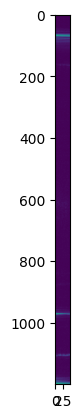

In [599]:
# plt.imshow(original_data[-100:,1172-200,250:320])
plt.imshow(original_data[0][:,-50:])

In [624]:
nn = [np.argmax(np.sum(original_data[i][n//2:1000],axis=1)) for i in range(original_data.shape[0])]
UP, DOWN = np.min(nn)-50,np.max(nn)+50
UP = UP if UP>0 else 0
DOWN = DOWN if DOWN<(1000-n//2) else (1000-n//2) 
UP,DOWN = UP+n//2,DOWN+n//2

print(UP,DOWN)

921 1000


In [575]:
mid = find_mid(original_data)
n = original_data.shape[1]

# finding the bright points in all images in standard interference
nn = [np.argmax(np.sum(original_data[i][:n//2],axis=1)) for i in range(original_data.shape[0])]

# intial correcting the y-motion
tf_all_nn = np.tile(np.eye(3),(original_data.shape[0],1,1))
for i in range(tf_all_nn.shape[0]):
    tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(0,-(nn[0]-nn[i]))))
for i in tqdm(range(original_data.shape[0]),desc='warping'):
    original_data[i][:mid]  = warp(original_data[i][:mid],AffineTransform(matrix=tf_all_nn[i]),order=3)

# finding the bright points in all images to crop the standard interference
nn = [np.argmax(np.sum(original_data[i][:n//2],axis=1)) for i in range(original_data.shape[0])]
UP, DOWN = np.min(nn)-80,np.max(nn)+80
UP = UP if UP>0 else 0
DOWN = DOWN if DOWN<original_data.shape[1] else original_data.shape[1]

print(UP,DOWN)

warping: 100%|██████████| 500/500 [00:07<00:00, 71.01it/s]


0 148


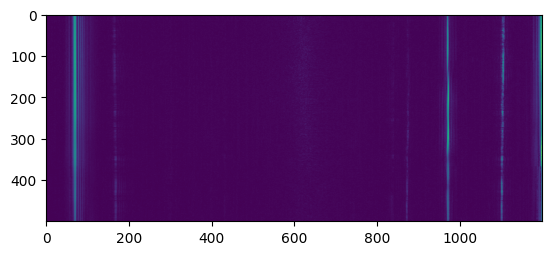

In [601]:
plt.imshow(original_data[:,:,:][:,:,400])

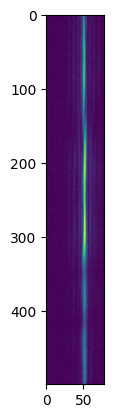

In [625]:
plt.imshow(original_data[:,UP:DOWN,:][:,:,400])

In [577]:
# better correcting the y-motion using functions
tr_all = ants_all_trans(original_data,UP,DOWN) # fucntion definition in util_funcs.py
for i in tqdm(range(original_data.shape[0]),desc='warping'):
    original_data[i][:mid]  = warp(original_data[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:07<00:00, 63.95it/s]


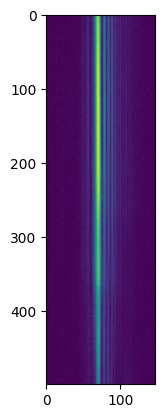

In [578]:
plt.imshow(original_data[:,UP:DOWN,:][:,:,400])

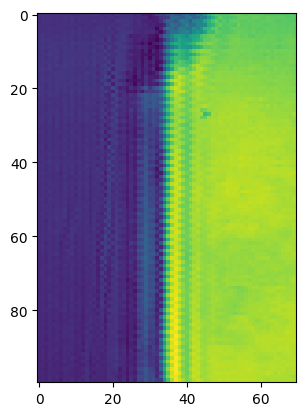

In [552]:
# temp_img = original_data[:,1172-200,270:320].copy()
temp_img = original_data[:,972,250:320].copy()

# tp = fft2(temp_img).flatten()
# tp[tp.shape[0]//2:] = 0
# # tp = np.where(np.abs(tp)>7.7,tp,0)
# temp_img = ifft2(tp.reshape(temp_img.shape)).real

plt.imshow(temp_img[0:100])

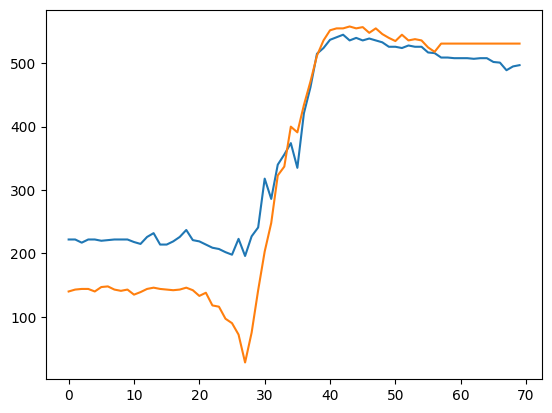

In [447]:
plt.plot(temp_img[302])
# plt.plot(denoise_signal(match_histograms(temp_img[340],temp_img[302]),rows=20))
plt.plot(scp.shift(temp_img[340],-12,mode='nearest'))

In [448]:
phase_cross_correlation(temp_img[302],temp_img[340],normalization=None,disambiguate=True)[0]

array([-6.])

In [449]:
minz(method='powell',fun = shift_func,x0 =(0),bounds = ([(-5,5)]),
                        args = (temp_img[302]
                                ,temp_img[340],0))['x']

array([-4.99999999])

In [553]:
def shift_func(shif, x, y , past_shift):
    x = scp.shift(x, -past_shift,order=3,mode='nearest')
    y = scp.shift(y, past_shift,order=3,mode='nearest')

    warped_x_stat = scp.shift(x, -shif[0],order=3,mode='nearest')
    warped_y_mov = scp.shift(y, shif[0],order=3,mode='nearest')

    return (1-ncc1d(warped_x_stat ,warped_y_mov))

def denoise_signal(errs , rows = 10):
    kk = fft(errs)
    kk[rows:] = 0
    kk = abs(ifft(kk))
    return kk

In [554]:
temp_img = original_data[:,972,250:320].copy()

In [555]:
sf = [0]
for i in tqdm(range(temp_img.shape[0]-1)):
        st = denoise_signal(temp_img[i],rows=500)
        mv = denoise_signal(temp_img[i+1],rows=500)
        rt = 0
        past_shift = 0
        for _ in range(10):
                move = minz(method='powell',fun = shift_func,x0 =(0),bounds = ([(-3,3)]),
                        args = (st
                                ,mv
                                ,past_shift))['x']

                past_shift += move[0]
                rt+=move[0]
        sf.append(rt*2)

100%|██████████| 499/499 [00:10<00:00, 47.96it/s]


In [556]:
sf = np.array(sf)
for i in range(1,sf.shape[0]):
    sf[i] += sf[i-1]

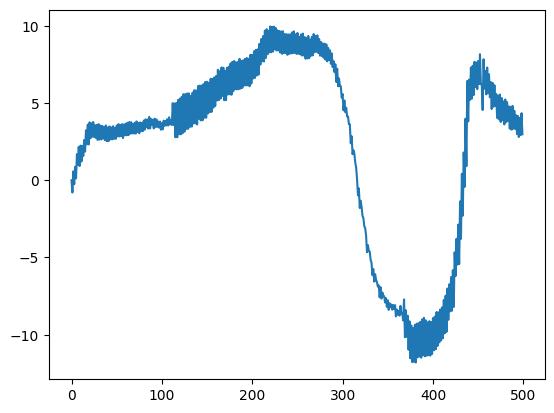

In [562]:
plt.plot(sf)

In [558]:
temp_img = original_data[:,64,:].copy()
for i in range(len(sf)):
    temp_img[i] = scp.shift(temp_img[i],sf[i],order=3)

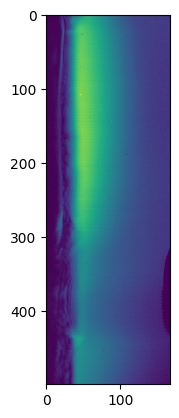

In [559]:
plt.imshow(temp_img[:,250:])

In [647]:
for i in tqdm(range(len(sf))):
    original_data[i] = scp.shift(original_data[i],shift = (0,sf[i]),order=3)

100%|██████████| 500/500 [00:25<00:00, 19.91it/s]


In [561]:
os.makedirs('test',exist_ok=True)
for i,j in tqdm(enumerate(original_data)):
    cv2.imwrite(f'test/'+f'frame_test{i}.PNG',j)

500it [00:03, 134.92it/s]


In [585]:
import time

In [648]:
nn = [np.argmax(np.sum(original_data[i][:n//2],axis=1)) for i in range(original_data.shape[0])]
UP, DOWN = np.min(nn)-50,np.max(nn)+50
UP = UP if UP>0 else 0
DOWN = DOWN if DOWN<original_data.shape[1] else original_data.shape[1]
standard_inter_UP,standard_inter_DOWN = UP,DOWN

nn = [np.argmax(np.sum(original_data[i][n//2:1000],axis=1)) for i in range(original_data.shape[0])]
UP, DOWN = np.min(nn)-50,np.max(nn)+50
UP = UP if UP>0 else 0
DOWN = DOWN if DOWN<(1000-n//2) else (1000-n//2) 
self_inter_UP,self_inter_DOWN = UP+n//2,DOWN+n//2

In [649]:
standard_inter_UP,standard_inter_DOWN,self_inter_UP,self_inter_DOWN

(18, 119, 921, 1000)

In [654]:
(1000-921)/2

39.5

In [650]:
crop = original_data[:,np.r_[standard_inter_UP:standard_inter_DOWN,self_inter_UP:self_inter_DOWN],:]

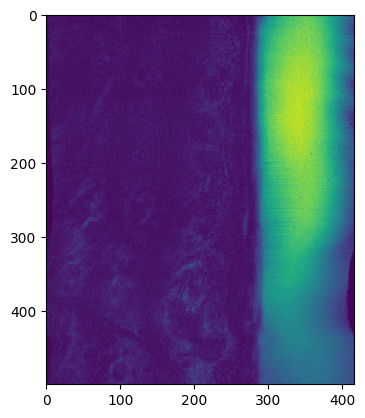

In [656]:
plt.imshow(crop[:,69,:])

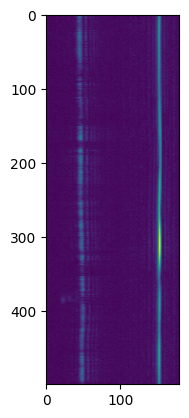

In [652]:
plt.imshow(crop[:,:,10])

In [ ]:
# done_scans = set([i for i in os.listdir('registered') if (i.startswith('scan'))])
# print(done_scans)
# scans = [i for i in os.listdir() if (i.startswith('scan')) and (i not in done_scans)]
# print('REMAINING',scans)
# for sc in scans:
#     print(f'Processing {sc}-----------------------------------------')
#     st = time.perf_counter()
#     run_scans(sc)
#     end = time.perf_counter()-st
#     print(f"Elapsed time: {end:.4f} seconds")
#     print(f'Done Processing {sc}------------------------------------')

In [658]:
set([i for i in os.listdir('registered') if (i.startswith('scan'))])

{'scan1',
 'scan10',
 'scan11',
 'scan12',
 'scan13',
 'scan14',
 'scan15',
 'scan16',
 'scan17',
 'scan18',
 'scan19',
 'scan2',
 'scan20',
 'scan21',
 'scan22',
 'scan23',
 'scan24',
 'scan25',
 'scan26',
 'scan27',
 'scan28',
 'scan29',
 'scan3',
 'scan30',
 'scan4',
 'scan5',
 'scan6',
 'scan7',
 'scan8',
 'scan9'}